# Uitwerkingen H7: 7.49

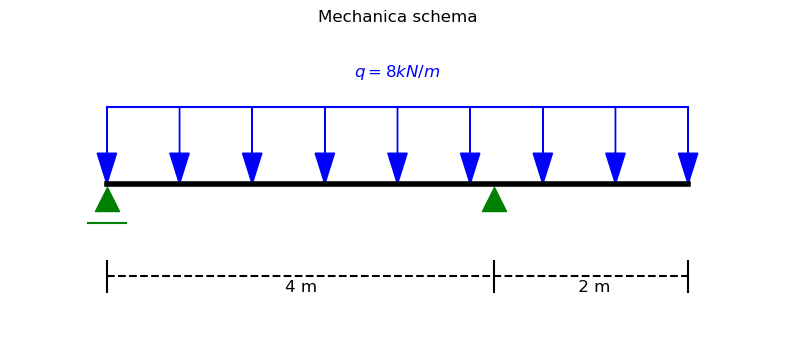

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches

# Instellen van de balklengte en belastingen
balk_lengte = 6  # meters
verdeelde_belasting = 8  # kN/m
koppel_locatie = 6  # meters
koppel_waarde = 160  # kNm (met de klok mee)

# Coördinaten van de ondersteuningen
ondersteuning_links = 0  # Rolscharnier
ondersteuning_rechts = 4  # Gewone scharnier

# Instellen van de figuur
fig, ax = plt.subplots(figsize=(10, 4))

# Tekenen van de balk
ax.plot([0, balk_lengte], [0, 0], 'k', lw=4, label="Balk")

# Tekenen van de ondersteuningen als gevulde groene driehoeken
ax.scatter(ondersteuning_links, -0.1, marker='^', s=300, color='green', label="Rolscharnier")
ax.plot([-0.2, 0.2], [-0.25, -0.25], color='green')  # Meetlijn
ax.scatter(ondersteuning_rechts, -0.1, marker='^', s=300, color='green', label="Scharnier")

# Tekenen van de verdeelde belasting met blauwe pijlen en label
x_vals = np.linspace(0, balk_lengte, 9)  
for x in x_vals:
    ax.arrow(x, 0.5, 0, -0.3, head_width=0.2, head_length=0.2, fc='blue', ec='blue')
ax.text(balk_lengte / 2, 0.7, r"$q = 8 kN/m$", fontsize=12, color='blue', ha='center')
ax.plot([0, balk_lengte], [0.5, 0.5], color='blue')  # Meetlijn

# Tekenen van het koppel met cirkelpijlen en blauwe label
#ax.text(koppel_locatie, 0.6, r"$M = 160\ kNm$", fontsize=12, color='blue', ha='center')
#ax.arrow(koppel_locatie - 0.3, 0.2, 0.3, 0.3, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linestyle='dashed')
#ax.arrow(koppel_locatie + 0.3, 0.2, -0.3, 0.3, head_width=0.1, head_length=0.1, fc='blue', ec='blue', linestyle='dashed')

# Tekenen van de maatvoering onder de balk
ax.plot([0, 0], [-0.5, -0.7], 'k')  # Begin meetlijn
ax.plot([4, 4], [-0.5, -0.7], 'k')  # Begin meetlijn
ax.plot([balk_lengte, balk_lengte], [-0.5, -0.7], 'k')  # Eind meetlijn
ax.plot([0, balk_lengte], [-0.6, -0.6], 'k--')  # Meetlijn
ax.text(10 / 2, -0.7, " 2 m", fontsize=12, ha='center')
ax.text(2, -0.7, "4 m", fontsize=12, ha='center')

# Maatvoering voor koppel locatie
#ax.plot([koppel_locatie, koppel_locatie], [-0.5, -0.4], 'k')  # Markering
#ax.text(koppel_locatie, -0.55, "6 m", fontsize=12, ha='center')

# Labels en titel in overeenstemming met template
ax.set_xlim(-1, balk_lengte + 1)
ax.set_ylim(-1, 1)
ax.set_xticks(np.arange(0, balk_lengte + 1, 1))
#ax.set_yticks([])
ax.set_xlabel(r"$x$", color="red", fontsize=14)
ax.set_ylabel(r"$z$", color="red", fontsize=14, rotation=0, labelpad=15)
ax.set_title("Mechanica schema")

# Koppelinstellingen
koppel_locatie = 6  # Positie van het koppel in meters
koppel_radius = 0.6  # Straal van de boog


# Bereken de positie van de pijlpunt op de boog
hoek_pijl = 90  # Pijlpunt bij 270 graden (onderkant boog)
pijl_x = 6.15 #koppel_locatie + (koppel_radius / 2) * np.cos(np.radians(hoek_pijl))
pijl_y = -0.25 #0.3 + (koppel_radius / 2) * np.sin(np.radians(hoek_pijl))

# Pijlpunt toevoegen aan de boog
#ax.add_patch(arc)
#ax.arrow(pijl_x, pijl_y, -0.02, -0.01, head_width=0.1, head_length=0.1, fc='blue', ec='blue')

# Label voor het koppel
#ax.text(koppel_locatie, -.45, r"$M = 160\ kNm$", fontsize=12, color='blue', ha='center')

# Legenda
#ax.legend()

# Assen uitschakelen
ax.axis('off')
#ax.grid()

# Creëer de boog voor het koppel
#arc = patches.Arc((koppel_locatie,-0), koppel_radius, koppel_radius, angle=270, theta1=20, theta2=180, color='blue', lw=2)
#ax.add_patch(arc)

# Plot weergeven
plt.show()


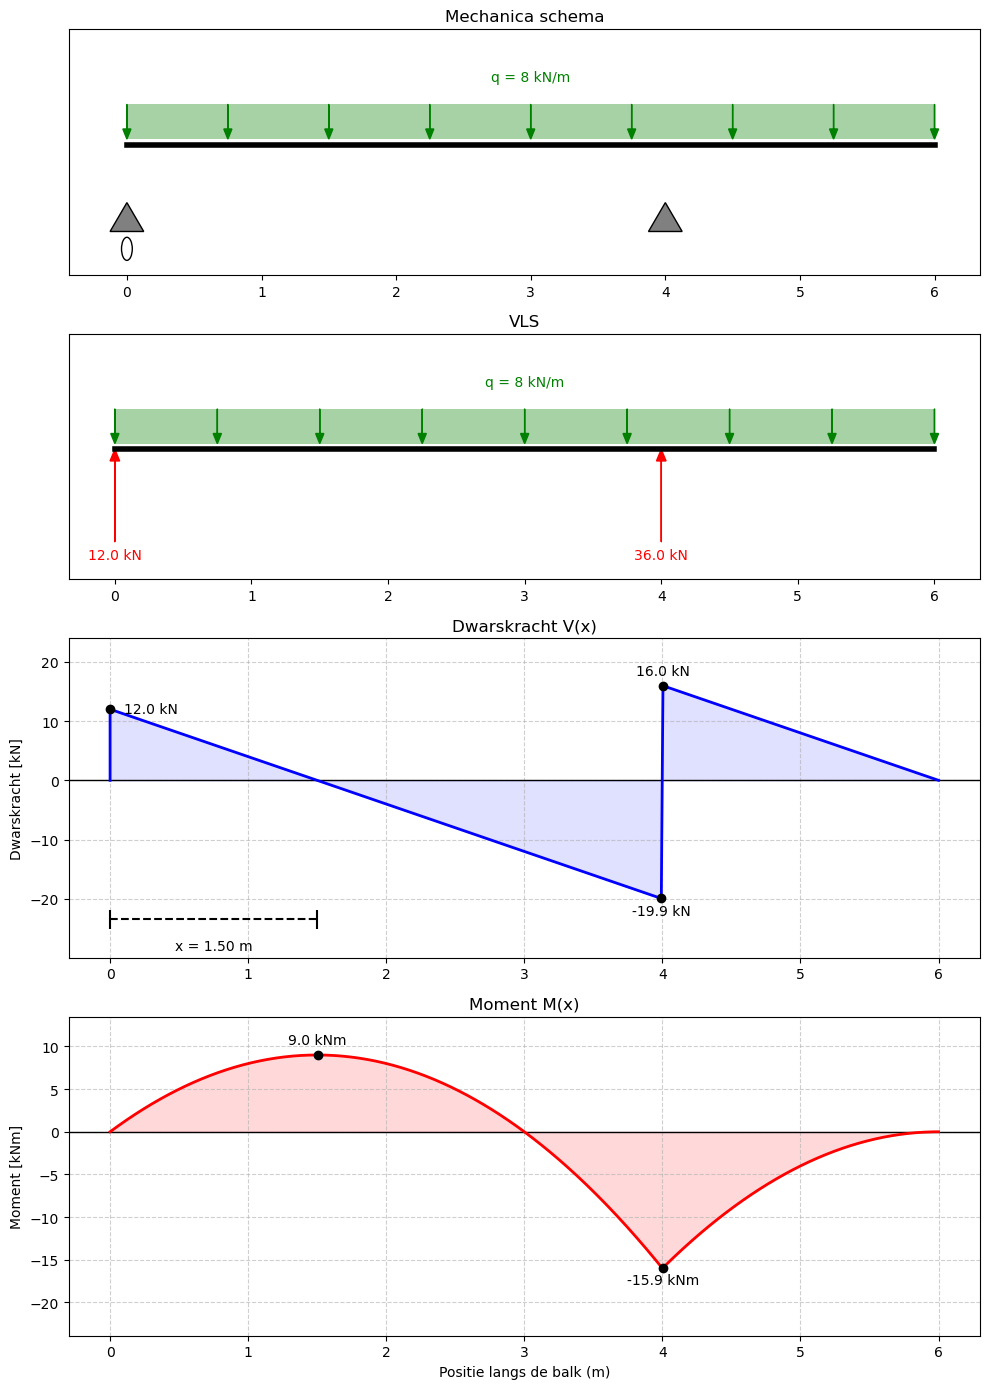

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Polygon, Circle

# ========================
# Parameters
# ========================
L = 6        # balklengte [m]
a = 4        # positie steun B [m]
q = 8        # verdeelde belasting [kN/m]

# ========================
# Reactiekrachten
# ========================
totale_last = q * L
R_B = totale_last * (L / 2) / a
R_A = totale_last - R_B

# ========================
# Discretisatie
# ========================
x = np.linspace(0, L, 500)
ticks = np.arange(0, L + 1, 1)

# ========================
# Dwarskracht V(x)
# ========================
V = np.zeros_like(x)
for i, xi in enumerate(x):
    if xi <= a:
        V[i] = R_A - q * xi
    else:
        V[i] = R_A + R_B - q * xi

xV = np.concatenate(([0], x, [L]))
V_plot = np.concatenate(([0], V, [0]))

iVmax, iVmin = np.argmax(V), np.argmin(V)
xVmax, Vmax = x[iVmax], V[iVmax]
xVmin, Vmin = x[iVmin], V[iVmin]

V0 = R_A          # waarde bij x=0
x_V0 = R_A / q    # nuldoorgang in eerste veld

# ========================
# Moment M(x)
# ========================
M = np.zeros_like(x)
for i, xi in enumerate(x):
    if xi <= a:
        M[i] = R_A * xi - 0.5 * q * xi**2
    else:
        M[i] = R_A * xi + R_B * (xi - a) - 0.5 * q * xi**2

xM = np.concatenate(([0], x, [L]))
M_plot = np.concatenate(([0], M, [0]))

iMmax, iMmin = np.argmax(M), np.argmin(M)
xMmax, Mmax = x[iMmax], M[iMmax]
xMmin, Mmin = x[iMmin], M[iMmin]

# ========================
# FIGUUR & SUBPLOTS (4 stuks)
# ========================
fig, (ax0, ax1, ax2, ax3) = plt.subplots(
    4, 1,
    figsize=(10, 14),
    gridspec_kw={'height_ratios': [1.0, 1.0, 1.3, 1.3]}
)

# Handige instellingen voor belastingblok/pijlen
blok_y0 = 0.02
blok_hoogte = 0.12
pijl_start_y = 0.14
pijl_dy = -0.12
aantal_pijlen = 9

# Kleine driehoeken (2× kleiner dan vorige)
tri_half = 0.125   # halve basis
tri_base_y = -0.30
tri_apex_y = -0.20
rol_radius = 0.04
rol_center_y = tri_base_y - 0.06

# =====================================================
# 0. MECHANICA SCHEMA
# =====================================================

# Balk
ax0.plot([0, L], [0, 0], color="black", linewidth=4)

# Groen blok belasting
belasting0 = Rectangle((0, blok_y0), L, blok_hoogte,
                       facecolor="green", alpha=0.35)
ax0.add_patch(belasting0)

# Groene pijlen
for xi in np.linspace(0, L, aantal_pijlen):
    ax0.arrow(
        xi, pijl_start_y,
        0, pijl_dy,
        head_width=0.06,
        head_length=0.035,
        color="green",
        length_includes_head=True
    )

ax0.text(L / 2, blok_y0 + blok_hoogte + 0.08,
         f"q = {q} kN/m", ha="center", color="green")

# Roloplegging op x=0 (driehoek punt omhoog + wiel)
rol_tri = Polygon(
    [[0 - tri_half, tri_base_y],
     [0 + tri_half, tri_base_y],
     [0,           tri_apex_y]],
    closed=True,
    facecolor="gray",
    edgecolor="black"
)
ax0.add_patch(rol_tri)
rol_wiel = Circle((0, rol_center_y), rol_radius,
                  facecolor="none", edgecolor="black")
ax0.add_patch(rol_wiel)

# Scharnieroplegging op x=a (alleen driehoek punt omhoog)
sch_tri = Polygon(
    [[a - tri_half, tri_base_y],
     [a + tri_half, tri_base_y],
     [a,           tri_apex_y]],
    closed=True,
    facecolor="gray",
    edgecolor="black"
)
ax0.add_patch(sch_tri)

ax0.set_ylim(-0.45, 0.4)
ax0.set_yticks([])
ax0.set_title("Mechanica schema")

ax0.set_xticks(ticks)
ax0.set_xticklabels(ticks)
ax0.grid(False)

# =====================================================
# 1. VLS
# =====================================================

ax1.plot([0, L], [0, 0], color="black", linewidth=4)

belasting1 = Rectangle((0, blok_y0), L, blok_hoogte,
                       facecolor="green", alpha=0.35)
ax1.add_patch(belasting1)

for xi in np.linspace(0, L, aantal_pijlen):
    ax1.arrow(
        xi, pijl_start_y,
        0, pijl_dy,
        head_width=0.06,
        head_length=0.035,
        color="green",
        length_includes_head=True
    )

ax1.text(L / 2, blok_y0 + blok_hoogte + 0.08,
         f"q = {q} kN/m", ha="center", color="green")

# Reactiekrachten (rood)
for xpos, R in [(0, R_A), (a, R_B)]:
    ax1.arrow(
        xpos, -0.32, 0, 0.32,
        head_width=0.07,
        head_length=0.04,
        color="red",
        length_includes_head=True
    )
    ax1.text(xpos, -0.38, f"{R:.1f} kN",
             ha="center", color="red")

ax1.set_ylim(-0.45, 0.4)
ax1.set_yticks([])
ax1.set_title("VLS")

ax1.set_xticks(ticks)
ax1.set_xticklabels(ticks)
ax1.grid(False)

# =====================================================
# 2. DWARSKRACHT V(x)
# =====================================================

ax2.axhline(0, color="black", linewidth=1)
ax2.plot(xV, V_plot, color="blue", linewidth=2)
ax2.fill_between(xV, V_plot, 0, color="blue", alpha=0.12)

ymin_V = 1.5 * V_plot.min()
ymax_V = 1.5 * V_plot.max()
ax2.set_ylim(ymin_V, ymax_V)

# V(0)
ax2.plot(0, V0, "ko")
ax2.annotate(f"{V0:.1f} kN",
             (0, V0),
             xytext=(10, 0),
             textcoords="offset points",
             ha="left",
             va="center")

# nuldoorgang maatlijn
y_dim = ymin_V + 0.12 * (ymax_V - ymin_V)
tick_h = 0.03 * (ymax_V - ymin_V)

ax2.hlines(y_dim, 0, x_V0, linestyles="dashed", colors="black")
ax2.vlines(0, y_dim - tick_h, y_dim + tick_h, colors="black")
ax2.vlines(x_V0, y_dim - tick_h, y_dim + tick_h, colors="black")
ax2.annotate(
    f"x = {x_V0:.2f} m",
    (x_V0 / 2, y_dim),
    xytext=(0, -14),
    textcoords="offset points",
    ha="center",
    va="top"
)

# max/min
ax2.plot(xVmax, Vmax, "ko")
ax2.annotate(f"{Vmax:.1f} kN",
             (xVmax, Vmax),
             xytext=(0, 8),
             textcoords="offset points",
             ha="center")

ax2.plot(xVmin, Vmin, "ko")
ax2.annotate(f"{Vmin:.1f} kN",
             (xVmin, Vmin),
             xytext=(0, -12),
             textcoords="offset points",
             ha="center")

ax2.set_ylabel("Dwarskracht [kN]")
ax2.set_title("Dwarskracht V(x)")
ax2.set_xticks(ticks)
ax2.set_xticklabels(ticks)
ax2.grid(True, linestyle="--", alpha=0.6)

# =====================================================
# 3. MOMENT M(x)
# =====================================================

ax3.axhline(0, color="black", linewidth=1)
ax3.plot(xM, M_plot, color="red", linewidth=2)
ax3.fill_between(xM, M_plot, 0, color="red", alpha=0.15)

ymin_M = 1.5 * M_plot.min()
ymax_M = 1.5 * M_plot.max()
ax3.set_ylim(ymin_M, ymax_M)

ax3.plot(xMmax, Mmax, "ko")
ax3.annotate(f"{Mmax:.1f} kNm",
             (xMmax, Mmax),
             xytext=(0, 8),
             textcoords="offset points",
             ha="center")

ax3.plot(xMmin, Mmin, "ko")
ax3.annotate(f"{Mmin:.1f} kNm",
             (xMmin, Mmin),
             xytext=(0, -12),
             textcoords="offset points",
             ha="center")

ax3.set_xlabel("Positie langs de balk (m)")
ax3.set_ylabel("Moment [kNm]")
ax3.set_title("Moment M(x)")
ax3.set_xticks(ticks)
ax3.set_xticklabels(ticks)
ax3.grid(True, linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()
